In [2]:
from google.colab import drive
import os
import zipfile
import shutil
drive.mount('/content/drive')
zip_path = "/content/drive/My Drive/dataset.zip"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode
import os


In [28]:
img_size = (224, 224)
train_dir = "/content/dataset/dataset/pokemon"
num_clusters = 100


In [17]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 9807 images belonging to 82 classes.


In [18]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

train_features = base_model.predict(train_generator)
print(f"Extracted features shape: {train_features.shape}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


307/307 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step
Extracted features shape: (9807, 1280)


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(train_features)

train_labels = train_generator.classes
ari = adjusted_rand_score(train_labels, train_clusters)
nmi = normalized_mutual_info_score(train_labels, train_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")




Adjusted Rand Index (ARI): 0.0558
Normalized Mutual Information (NMI): 0.2825


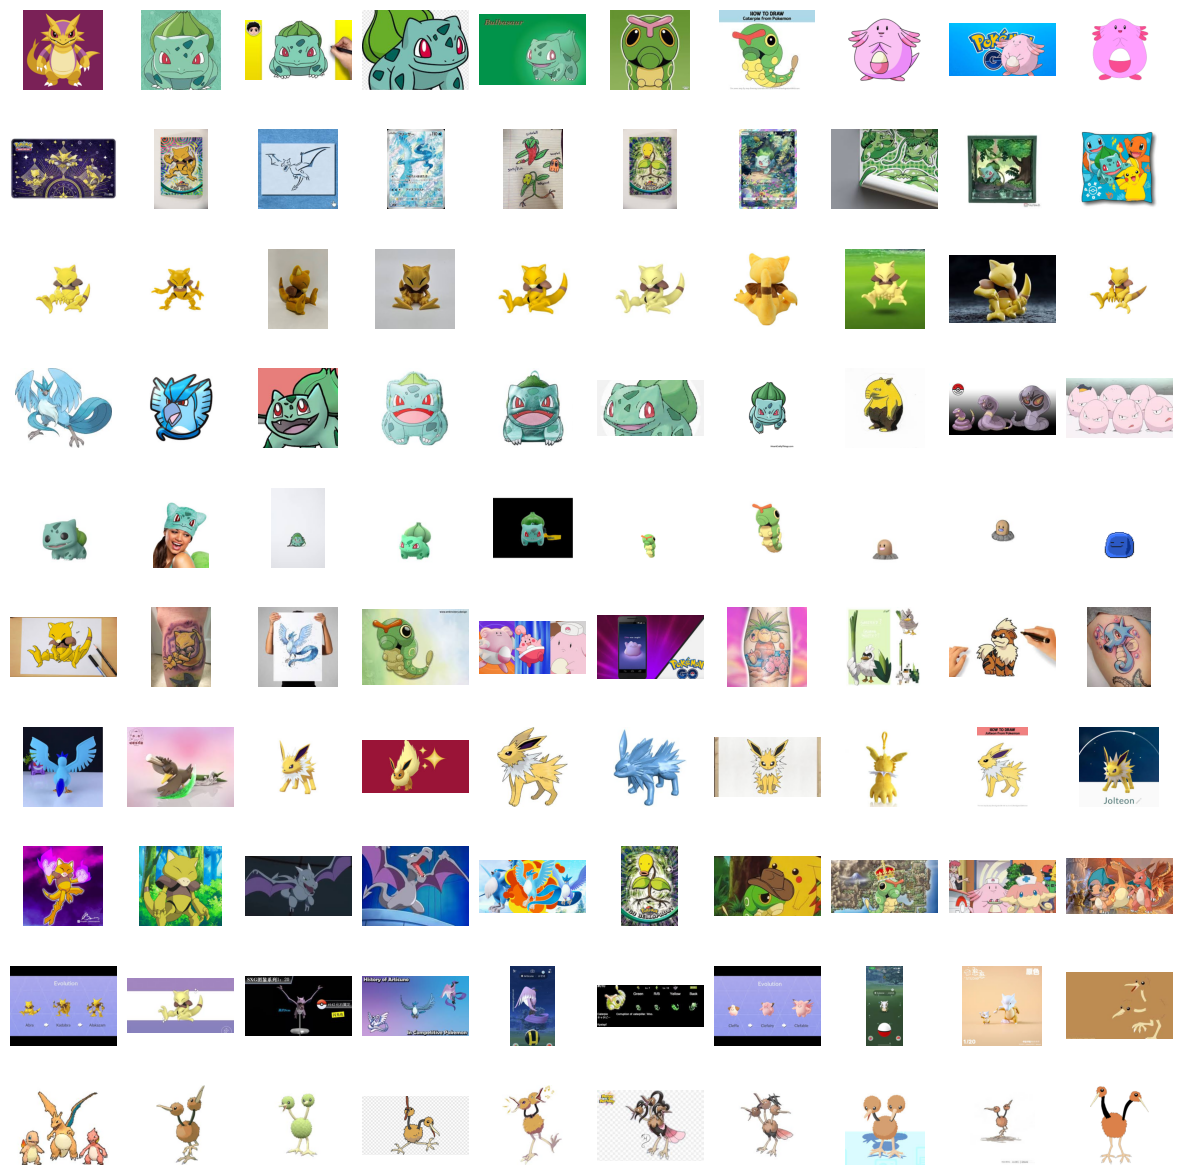

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
image_paths = [os.path.join(train_dir, fname) for fname in train_generator.filenames]
num_clusters_to_show = 10
images_per_cluster = 10
fig, axes = plt.subplots(num_clusters_to_show, images_per_cluster, figsize=(15, 15))
for cluster_id in range(num_clusters_to_show):
    cluster_indices = np.where(train_clusters == cluster_id)[0]
    num_images = min(images_per_cluster, len(cluster_indices))

    for i in range(num_images):
        idx = cluster_indices[i]
        img = Image.open(image_paths[idx])
        axes[cluster_id, i].imshow(img)
        axes[cluster_id, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()


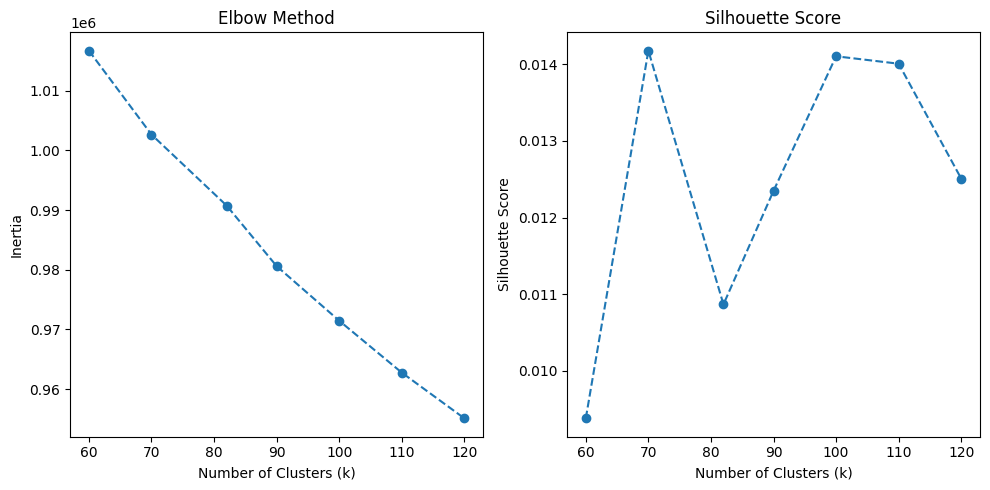

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


k_values = [60, 70, 82, 90, 100, 110, 120]
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_features)

    inertia.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(train_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from PIL import Image

img_size = (64, 64)

def extract_hog_features_from_directory(directory):
    features = []
    labels = []

    for label, pokemon_class in enumerate(os.listdir(directory)):
        pokemon_dir = os.path.join(directory, pokemon_class)
        if os.path.isdir(pokemon_dir):
            for image_name in os.listdir(pokemon_dir):
                image_path = os.path.join(pokemon_dir, image_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, img_size)
                features_hog, _ = hog(image, block_norm='L2-Hys', pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
                features.append(features_hog)
                labels.append(label)

    return np.array(features), np.array(labels)

features, labels = extract_hog_features_from_directory(train_dir)
print(f"Extracted features shape: {features.shape}")

scaler = StandardScaler()
features = scaler.fit_transform(features)

pca = PCA(n_components=100)
features_reduced = pca.fit_transform(features)
print(f"Reduced features shape: {features_reduced.shape}")

kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(features_reduced)

ari = adjusted_rand_score(labels, train_clusters)
nmi = normalized_mutual_info_score(labels, train_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Extracted features shape: (9807, 8100)
Reduced features shape: (9807, 100)
Adjusted Rand Index (ARI): 0.0054
Normalized Mutual Information (NMI): 0.1352


In [ ]:
image_paths = []
for pokemon_class in os.listdir(train_dir):  
    pokemon_dir = os.path.join(train_dir, pokemon_class)
    if os.path.isdir(pokemon_dir):  
        for file in os.listdir(pokemon_dir):  
            if file.lower().endswith((".png", ".jpg", ".jpeg")):  
                image_paths.append(os.path.join(pokemon_dir, file))

print(f"Length of image_paths: {len(image_paths)}")
print(f"Length of train_clusters: {len(train_clusters)}")

Length of image_paths: 9807
Length of train_clusters: 9807


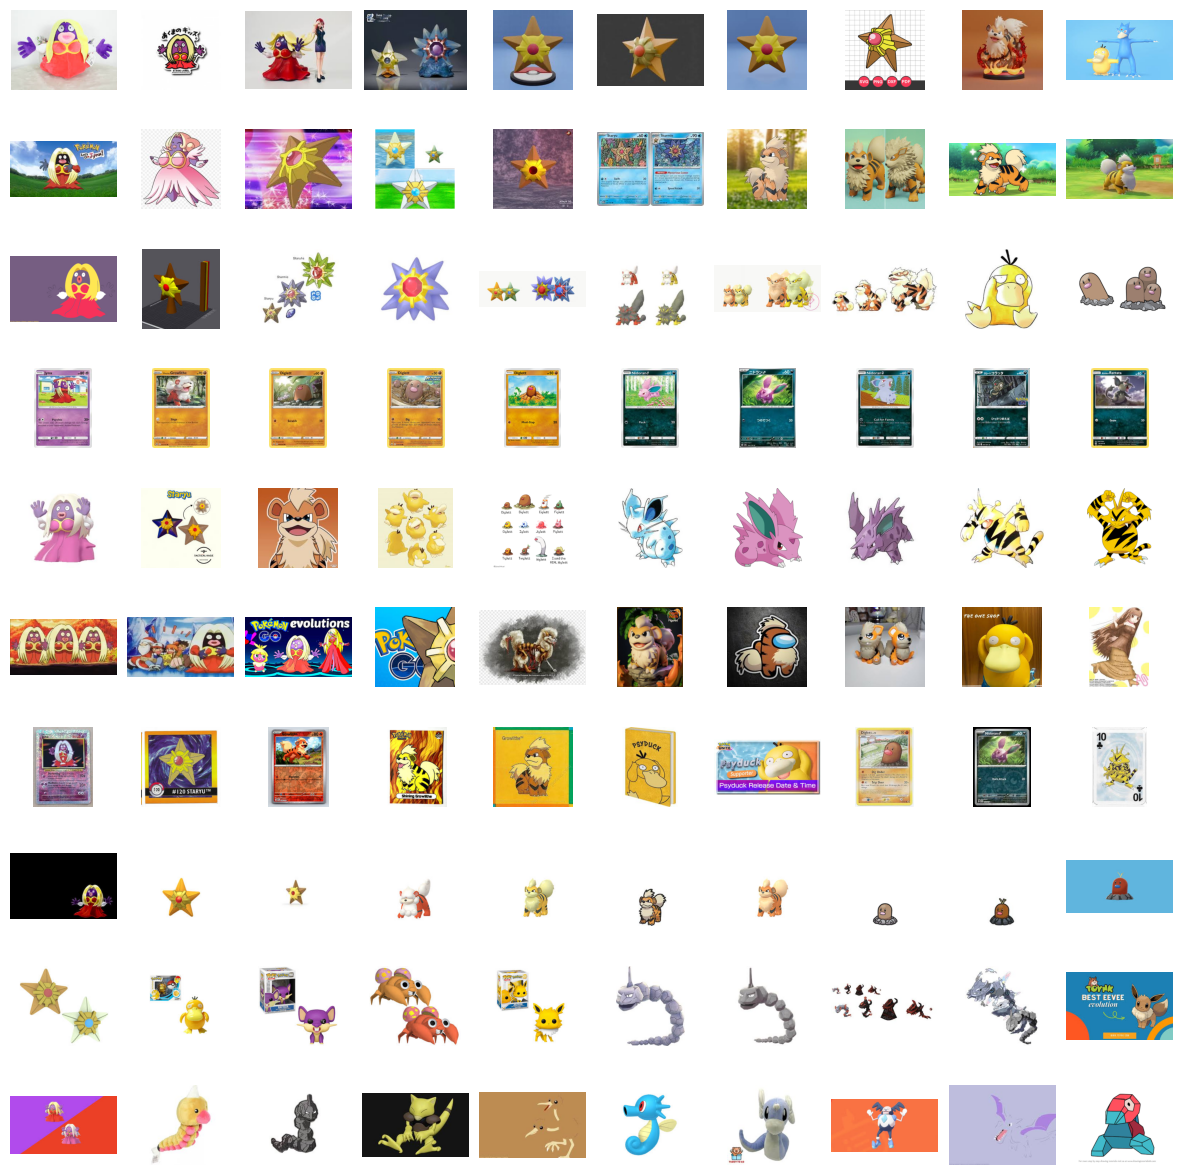

In [35]:
num_clusters_to_show = 10
images_per_cluster = 10

fig, axes = plt.subplots(num_clusters_to_show, images_per_cluster, figsize=(15, 15))

for cluster_id in range(num_clusters_to_show):
    cluster_indices = np.where(train_clusters == cluster_id)[0]
    num_images = min(images_per_cluster, len(cluster_indices))

    for i in range(num_images):
        idx = cluster_indices[i]
        img = Image.open(image_paths[idx])
        axes[cluster_id, i].imshow(img)
        axes[cluster_id, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()